# Does Diabetes Correlate With Affluence?

Bill Alive

*Last updated: 2022 Sep 15*

```{figure} assets/prediabetes-cdc.png
---
width: 600px
---
Source: [CDC](https://www.cdc.gov/diabetes/images/library/socialmedia/DiabetesInTheUS_Print-1-image_1.jpg)
```

<style>
    figcaption { padding: 0; font-size: 0.8em; }
    figcaption p { margin-bottom: 0; }
    .caption-number { display: none; visibility: hidden; }
</style>

## Motivation

According to the CDC, the overwhelming majority of diabetes cases (Type 2) can be “prevented or delayed with healthy lifestyle changes”. 

Yet in the United States:

* Diabetes is the **7th** leading cause of **death**.

* About **1 in 10** people have diabetes (37 million), and **more than 1 in 3 adults** (96 million) have prediabetes.

* And these numbers are **growing**. Diabetes diagnoses for adults have more than **doubled** in the last two decades.[^diabetes-stats]

Is this an inevitable risk of affluence? Or can other wealthy countries give hints of how we might reduce this threat? 

On the other hand, what if poorer countries have high rates too?

[^diabetes-stats]: Source: CDC, ["What is Diabetes?"](https://www.cdc.gov/diabetes/basics/diabetes.html) Accessed 2022 Sep 15.

## Research Question

### Do higher income countries tend to have higher rates of diabetes?

If they do, the problem seems obvious: more wealth means easier access to food and less need for physical activity, both of which increase this risk.

But what if some poorer countries have rates as high (or higher!) than the US? And what if some other wealthy countries have much lower rates?



:::{note}
This notebook is adapted from a project for my [MicroMasters in Data Science from UC San Diego](/certification.md).

The original assignment imposed a strict template and fairly simple options for analysis.

But the results still surprised me.

:::

## Our Dataset

### World Bank: World Development Indicators

```{image} ../assets/world-bank-logo.png
:width: 150px
:alt: World Bank Logo
:align: right
```

The [World Development Indicators dataset](https://datatopics.worldbank.org/world-development-indicators/) is the “World Bank’s premier compilation of cross-country comparable data on development.”

The full dataset includes data from 1960 to 2021. Each row consists of a country (or country grouping, like “High income”), an indicator, and then, for each year, a separate column holding that indicator’s value for that country in that year. 

For this project, let's focus on a single year of data. 

:::{seealso}
You can view the 
{download}`original PDF report <output/22715-Does_Diabetes_Correlate_With_Affluence__2014_Data__Bill_Alive.pdf>` for this project.

For the original project, the most recent data available was for **2014**. Although the conclusions were the same, the data for individual countries were significantly different. Here, we will use a more recent year.
:::

## Setup

```{image} ../assets/python-logo.png
:width: 200px
:alt: Python Logo
:align: right
```

In [71]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from adjustText import adjust_text

### Helper Functions

Let's define a few helper functions for this project.

In [70]:
## TABLES

def row_style(row):
    ## The index is the country name.
    if row.name in 'United States':
        return ['background-color: yellow'] * len(row)

    
def missing_data_style(v):
    return 'background-color: red; color: white; font-weight: bold;' if v == 0 else None
    

def country_style(s):
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.io.formats.style.Styler.apply_index.html#pandas.io.formats.style.Styler.apply_index
    return np.where(s == "United States", "background-color: yellow;", "")
    
    
def country_color(idx, countries, color):
    return f"color: {color};" if idx in countries else None
    

def ind(df, indicators, sort_index=0, countries=None):
    """Given indicator(s), show the top results.
    
    Parameters:
      df: dateset (one year of data, pivoted)
      indicators: list of one or more indicators
      sort_index: index of column in indicators to sort by.
      countries: show only rows with these countries as index.
    """
    df = df[indicators]
        
    if countries:
        df = df.loc[countries]
                
    df = df.sort_values(indicators[sort_index], ascending=False)
    return df


def show_df(df, head=None, caption=""):
    """Format df for display."""
    global year
    ## https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Finer-Control:-Display-Values
    if head:
        df = df.head(head)
    return df.style.format(precision=2, na_rep='MISSING', thousands=",")\
        .set_table_styles(table_styles)\
        .apply_index(country_style)\
        .applymap(missing_data_style)\
        .set_caption(f"{caption} ({year})")


def s(df, indicators, countries='countries', head=10, sort_index=0, caption=""):
    """Show indicator(s) for pivoted table (one year's data), 
    filtered to particular countries or groups.
    
    Parameters:
      df: dateset (one year of data, pivoted)
      indicators: list of one or more indicators
      sort_index: index of column in indicators to sort by
      countries: show only rows with these countries as index
      head: show only this number of rows
    """
    countryName=data['Country Name'].unique().tolist()
    first_country='Afghanistan'
    
    ## For countries, pass either a keyword or an actual list of countries.
    ## Default is to show only country names.
    if countries=='countries':
        countries = countryName[countryName.index(first_country):]
    elif countries=='groups':
        countries = countryName[0:countryName.index(first_country)]
    else:
        assert(isinstance(countries, list))
        
    df_ind = ind(df, indicators,countries=countries, sort_index=sort_index)    
    return show_df(df_ind,head=head,caption=caption)


## CHARTS

def add_country(df, plt, country, label=None,box=None,c=None):
    if label is None:
        label = country
        
    df = df.loc[country]
    X = df[ind_gni_per_capita]
    Y = df[ind_diabetes]
    
    if box:
        bbox=dict(facecolor=box, alpha=1)
    else:
        bbox=None
    
    # Draw this country's point.
    if c is not None:
        plt.scatter(X,Y,s=30,c=c)
    
    # Only use this function for individual points.
    plt.text(X+2, Y+2, label, bbox=bbox)
    return
    
    
def collect_texts(df_list, colors, xf, yf):
    texts = []
    for df, color in zip(df_list, colors):
        countries = list(df.index)
        for x, y, country in zip(df[xf], df[yf], countries):
            texts.append(plt.text(x,y,country,color=color))
    return texts
    
    
def plot_countries(axis,plt,df,color,dot_size):
    X = df[ind_gni_per_capita]
    Y = df[ind_diabetes]
    axis.scatter(X,Y,s=dot_size,c=color)
    return


def config_axis(axis,plt,df,xlim,ylim):
    axis.yaxis.grid(True)
    axis.set_xlabel("Per Capita Income",fontsize=10)
    axis.set_ylabel("Diabetes prevalence",fontsize=10)
    X = df[ind_gni_per_capita]
    Y = df[ind_diabetes]
    axis.set_adjustable('box')
    axis.set_xbound(lower=-500, upper=xlim)
    axis.set_ybound(lower=-0.2, upper=ylim)
    # TODO Get set_xlim and set_ylim to work properly.
    # Currently, they add much more than specified to the axes, which
    # makes the origin (0,0) too far from the bottom left corner.
    # axis.set_xlim(left=-500, right=xlim)
    # axis.set_ylim(bottom=-0.2, top=ylim)
    axis.tick_params(axis='x',labelrotation=45)
    axis.set_xticks(axis.get_xticks().tolist())
    axis.set_yticks(axis.get_yticks().tolist())
    plt.gca().set_xticklabels(['${:,.0f}'.format(x) for x in plt.gca().get_xticks()])
    plt.gca().set_yticklabels(['{:,.0f}%'.format(y) for y in plt.gca().get_yticks()])
    return X, Y


## VARIABLES

# Colors
color_wealth = 'lightgreen'
color_diabetes = 'pink'

# Formats
fmt_usd = "${:20,.0f}"
fmt_percent = "{:20,.1f}%"

# Styles
table_styles = [ 
    dict(selector="caption", \
         props=[("caption-side", "bottom"),\
                ("text-align","left"),\
                ("padding-top","1em"),\
                ("color","gray")
               ])
]

## Data Preparation and Cleaning

Let's import the data and look at the first few rows.

:::{seealso}
For the helper functions I wrote to prepare the WDI dataset, see my [WDI helper functions](../lib/WDI.ipynb).
:::

In [3]:
%run ../lib/WDI.ipynb
data = get_wdi()
data.head(5)

Country Name Country Code  \
0  Africa Eastern and Southern          AFE   
1  Africa Eastern and Southern          AFE   
2  Africa Eastern and Southern          AFE   
3  Africa Eastern and Southern          AFE   
4  Africa Eastern and Southern          AFE   

                                      Indicator Name     Indicator Code  1960  \
0  Access to clean fuels and technologies for coo...     EG.CFT.ACCS.ZS   NaN   
1  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.RU.ZS   NaN   
2  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.UR.ZS   NaN   
3            Access to electricity (% of population)     EG.ELC.ACCS.ZS   NaN   
4  Access to electricity, rural (% of rural popul...  EG.ELC.ACCS.RU.ZS   NaN   

   1961  1962  1963  1964  1965  ...       2013       2014       2015  \
0   NaN   NaN   NaN   NaN   NaN  ...  16.936004  17.337896  17.687093   
1   NaN   NaN   NaN   NaN   NaN  ...   6.499471   6.680066   6.859110   
2   NaN   NaN   NaN   NaN   NaN  ...  37.855399  38.046781  38.326255   
3   NaN   NaN   NaN   NaN   NaN  ...  31.794160  32.001027  33.871910   
4   NaN   NaN   NaN   NaN   NaN  ...  18.663502  17.633986  16.464681   

        2016       2017       2018       2019       2020  2021  Unnamed: 66  
0  18.140971  18.491344  18.825520  19.272212  19.628009   NaN          NaN  
1   7.016238   7.180364   7.322294   7.517191   7.651598   NaN          NaN  
2  38.468426  38.670044  38.722783  38.927016  39.042839   NaN          NaN  
3  38.880173  40.261358  43.061877  44.270860  45.803485   NaN          NaN  
4  24.531436  25.345111  27.449908  29.641760  30.404935   NaN          NaN  

[5 rows x 67 columns]

### Choose Our Indicator

Let's find the most relevant indicator that includes the word "diabetes":

In [4]:
list(data[data['Indicator Name'].str.contains('diabetes',case=False)]['Indicator Name'].unique())

['Diabetes prevalence (% of population ages 20 to 79)',
 'Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)',
 'Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70, female (%)',
 'Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70, male (%)']

All right. Clearly, our best indicator is: `'Diabetes prevalence (% of population ages 20 to 79)'`

In [23]:
ind_diabetes='Diabetes prevalence (% of population ages 20 to 79)'

### Which Year Should We Use?

Strangely, many years in this dataset have no data for diabates prevalence. Let's choose the most recent year for which we have sufficient data.

We'll sort each year by the number of empty entries for this indicator.

In [6]:
data[data['Indicator Name'].str.contains(str(ind_diabetes),regex=False,case=False)].isna().sum(axis=0).sort_values(ascending=True).head(10)

Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
2021                6
2011               13
2000              248
2003              266
2002              266
2001              266
dtype: int64

### Our Choice: 2021

Wow. **2021** has data for diabetes prevalence on almost every country and group, but then there's almost no data for any other year. 

Looks like we'll use 2021.

In [7]:
year = 2021

### Pivot

With our year chosen, we can **pivot** this table. This gives a dataset that contains:

- Only data for our chosen year.
- One row for each country.
- One column for each country.

This makes it easy to show data for any indicator we like. 

In [8]:
# Prepare pivoted dataframe with countries only.
df = wdi_remove_groups(data)
df = wdi_pivot(df, year=year,index_column='Country Name', pivot_column='Indicator Name')

# Also prepare a separate dataframe with all data, for select charts.
df_all = wdi_pivot(data, year=year,index_column='Country Name', pivot_column='Indicator Name')

display(df)

Indicator Name         Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)  \
Country Name                                                                                                                             
Afghanistan                                                         9.65                                                                 
Albania                                                            44.17                                                                 
Algeria                                                            44.10                                                                 
American Samoa                                                      0.00                                                                 
Andorra                                                             0.00                                                                 
...                                                                  ...                                                                 
Virgin Islands (U.S.)                                               0.00                                                                 
West Bank and Gaza                                                 33.64                                                                 
Yemen, Rep.                                                         0.00                                                                 
Zambia                                                             48.52                                                                 
Zimbabwe                                                           59.75                                                                 

Indicator Name         Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)  \
Country Name                                                                                                                                     
Afghanistan                                                         4.70                                                                         
Albania                                                            45.69                                                                         
Algeria                                                            31.19                                                                         
American Samoa                                                      0.00                                                                         
Andorra                                                             0.00                                                                         
...                                                                  ...                                                                         
Virgin Islands (U.S.)                                               0.00                                                                         
West Bank and Gaza                                                 25.93                                                                         
Yemen, Rep.                                                         0.00                                                                         
Zambia                                                             44.98                                                                         
Zimbabwe                                                           53.98                                                                         

Indicator Name         Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)  \
Country Name                                                                                                                                   
Afghanistan       

:::{note} 

Those indicator names are a bit unwieldy, aren't they? You might prefer to work with the `Indicator Code` column, as I do in ["Do Countries Have Synthetic Traits?"](../22719-country-synthetic-traits/index.ipynb). 

But for this project, it would add a tedious extra step to keep looking up the code for each indicator name.
:::

Here's a sample of diabetes prevalence percentages for 2021, with one row per country.  

In [9]:
df[ind_diabetes]

Country Name
Afghanistan              10.9
Albania                  10.2
Algeria                   7.1
American Samoa           20.3
Andorra                   9.7
                         ... 
Virgin Islands (U.S.)    12.4
West Bank and Gaza        9.2
Yemen, Rep.               5.4
Zambia                   11.9
Zimbabwe                  2.1
Name: Diabetes prevalence (% of population ages 20 to 79), Length: 217, dtype: float64

### Full Indicator List
To see all available indicators, click to expand the cell below.

In [10]:
list(df.columns)

['Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, older adults (% of population ages 25+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, poorest 40% (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, primary education or less (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, richest 60% (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, secondary education

## Which countries have the most wealth?

Since we are focusing on how income affects individual lifestyles, let's look at Gross National Income (GNI), rather than the usual Gross Domestic Product (GDP).

### Gross National Income (GNI)

:::{sidebar}

> GNI calculates the total **income earned** by a nation's people and businesses, including investment income, regardless of where it was earned. It also covers **money received from abroad** such as foreign investment and economic development aid. *(Emphasis added.)*

-- [Investopedia](https://www.investopedia.com/terms/g/gross-national-income-gni.asp)
:::

In [21]:
ind_gni='GNI (current US$)'

s(df, [ind_gni], countries="countries",\
  caption="Wealthiest countries by GNI")\
    .format({ind_gni: fmt_usd})\
    .bar(subset=[ind_gni], color=color_wealth,vmin=0)

### GNI Per Capita

Wait, though. We want to know whether *individual* wealth correlates with diabetes. Instead of total income for the entire country, which countries have the most income *per person*?

In [20]:
ind_gni_per_capita='GNI per capita, Atlas method (current US$)' 
max_gni_per_capita=max(df[ind_gni_per_capita])

s(df, [ind_gni_per_capita, ind_gni], countries="countries",\
     caption="Wealthiest countries by GNI per capita")\
    .format({ind_gni: fmt_usd, ind_gni_per_capita: fmt_usd})\
    .bar(subset=[ind_gni], color=color_wealth,vmin=0)\
    .bar(subset=[ind_gni_per_capita], color=color_wealth,vmin=0)

Interesting! In **2021**, only the United States is in both top 10 lists. Why?

Let's examine the GNI per capita for the "wealthiest" countries by GNI.

### GNI Per Capita for the "Wealthiest" Countries

In [22]:
countries_top_gni = list(df[ind_gni].sort_values(ascending=False).head(10).index)

s(df, [ind_gni, ind_gni_per_capita], countries=countries_top_gni,\
     caption="Wealthiest countries by GNI, with GNI per capita")\
    .format({ind_gni: fmt_usd, ind_gni_per_capita: fmt_usd})\
    .bar(subset=[ind_gni], color=color_wealth,vmin=0)\
    .bar(subset=[ind_gni_per_capita], color=color_wealth,vmin=0,vmax=max_gni_per_capita)

Hmm. We see some stark contrasts.

In **2021**, although China had the second highest GNI, each person's share was around *one sixth* that of a United States resident.

And India, with a GNI of over \$3 trillion, roughly as much as UK and France, had a per capita income of only **\$2,170**, compared to **\$45,380** and **\$43,880**, respectively.

But even the "wealthiest" country, the United States, has a GNI per capita (**\$70,430**) that is not quite two-thirds that of the top ranker from our previous chart, Bermuda (**\$116,540**).

:::{admonition} For Further Research
:class: tip

*What is going on* in Bermuda???
:::

### Focus on GNI Per Capita

It seems that the national GNI may be highly misleading here. GNI per capita will give us a much better sense of individual wealth. 

Even so, this an indicator not perfect. A country with 1 trillion in GNI and only two residents, one of whom is broke, would have a GNI per capita of half a billion dollars.

More realistically, if the bottom 90% of people is sharing only 50% of the wealth, then the average of *their* per capita income will be *half* the official average.

Ideally, we could also examine the income distribution in each population. The WDI dataset does provide indicators that could help, such as `Income share held by highest 20%`,  `Income share held by second 20%`, and so on. 

Unfortunately, none of those indicators had any data for this year.

For now, GNI per capita will give us a rough approximation of individual wealth.

## Which Countries Have the Highest Rates of Diabetes?

### Countries With Highest Diabetes Prevalence

In [15]:
ind_name=ind_diabetes
s(df, [ind_name], countries='countries',\
 caption="Countries with Highest Diabetes Prevalence")\
    .format({ind_name: fmt_percent})\
    .bar(subset=[ind_name], color=color_diabetes,vmin=0)

Wow. The **United States isn't even in that list**! Neither are any other countries with the top GNI or GNI per capita.

Let's get the diabetes rates for countries with the highest GNI per capita.

### Diabetes Prevalence for Wealthiest Countries

In [16]:
countries_top_gni_per_capita = list(df[ind_gni_per_capita].sort_values(ascending=False).head(10).index)
max_diab=max(df[ind_diabetes])

s(df, [ind_gni_per_capita, ind_diabetes], countries=countries_top_gni_per_capita,\
 caption="Diabetes prevalence for wealthiest countries (GNI per capita)")\
    .bar(subset=[ind_diabetes], color=color_diabetes,vmin=0,vmax=max_diab)\
    .bar(subset=[ind_gni_per_capita], color=color_wealth,vmin=0,vmax=max_gni_per_capita)\
    .format({ind_diabetes: fmt_percent, ind_gni_per_capita: fmt_usd})\
    .set_table_styles(table_styles)

What is going on? Except for Qatar, the diabetes rates for these wealthy countries are **below 15%**, or even **10%**. 

By contrast, the countries with the highest diabetes rates are **over 20%**, even **30%**.

Do we have this precisely backwards? Are the poorest countries **more** at risk of diabetes?

### GNP Per Capita for Top Diabetes Prevalence

In [24]:
countries_top_diabetes = list(df[ind_diabetes].sort_values(ascending=True).tail(10).index)
max_diab=max(df[ind_diabetes])

s(df, [ind_diabetes, ind_gni_per_capita], countries=countries_top_diabetes,\
 caption="Countries with highest diabetes prevalence, with GNI per capita")\
    .bar(subset=[ind_diabetes], color=color_diabetes,vmin=0,vmax=max_diab)\
    .bar(subset=[ind_gni_per_capita], color=color_wealth,vmin=0,vmax=max_gni_per_capita)\
    .format({ind_diabetes: fmt_percent, ind_gni_per_capita: fmt_usd})\
    .set_table_styles(table_styles)

Hmm. At first, it looks like these countries with the highest diabetes prevalence certainly seem on the lower end of the income scale.

Btu for several of these countries, **GNI per capita equals 0.**

This is impossible, so it has to be **missing data**.


### GNP Per Capita for Top Diabetes Prevalence, Excluding Missing GNI Data

Let's look again at the countries with the highest diabetes prevalence, but filter out countries with missing GNI data.

In [25]:
df2=df[df[ind_gni_per_capita] != 0]
s(df2, [ind_diabetes, ind_gni_per_capita], countries=list(df2.index),\
 caption="Countries with highest diabetes prevalence, with GNI per capita\n(Excluding countries with missing GNI per capita data)")\
    .bar(subset=[ind_diabetes], color=color_diabetes,vmin=0,vmax=max_diab)\
    .bar(subset=[ind_gni_per_capita], color=color_wealth,vmin=0,vmax=max_gni_per_capita)\
    .format({ind_diabetes: fmt_percent, ind_gni_per_capita: fmt_usd})\
    .set_table_styles(table_styles)

Even after filtering out countries with missing GNI per capita, we are still looking at mostly lower income countries here. 

The one exception is **Qatar**, which is also in our list of wealthiest countries.

Still, it's not clear whether these are *extremely* low incomes, or whether there is any correlation at all. Let's investigate further.

### Diabetes by Income Bracket

The WDI dataset includes groupings by income. Let's do a quick sanity check and see what the diabetes rates are for `High Income`, `Middle Income`, and `Low Income` countries.

In [27]:
income_brackets=['High income', 'Middle income', 'Low income']
s(df_all, [ind_diabetes], countries=income_brackets,\
 caption="Diabetes prevalence by country income brackets")\
    .bar(subset=[ind_diabetes],color=color_diabetes,vmin=0,vmax=max_diab)\
    .format({ind_diabetes: fmt_percent})\
    .set_table_styles(table_styles)

Interesting. The lowest income countries still have the lowest diabetes rate, but the *middle* income countries actually have the highest rate.

But look again at how high the diabetes rates are for the countries with the highest rates: well over 20%. These averages aren't anywhere near those numbers. 

Income may not be useful an indicator for diabetes.

## Findings: Scatterplot Charts

So far, we've examined the data using tables. Now, let's use scatterplots to see whether high and low diabetes prevalence correlate with GNI per capita.


Perhaps the visual overview will reveal patterns we've missed.

### Remove Countries With Missing Data

:::{note}
For the rest of this report, we will **exclude countries with missing data**. 

If a country does not have data for this year on either diabetes prevalence or GNI per capita, it is excluded from the remaining analysis.
:::

In [28]:
# Remove missing data.
df = df[df[ind_diabetes] != 0]
df = df[df[ind_gni_per_capita] != 0]
df.shape

(171, 520)

### Diabetes Prevalence and GNI per capita, All Countries

In this scatter plot, each point shows a country’s diabetes
prevalence compared with its GNI per capita.

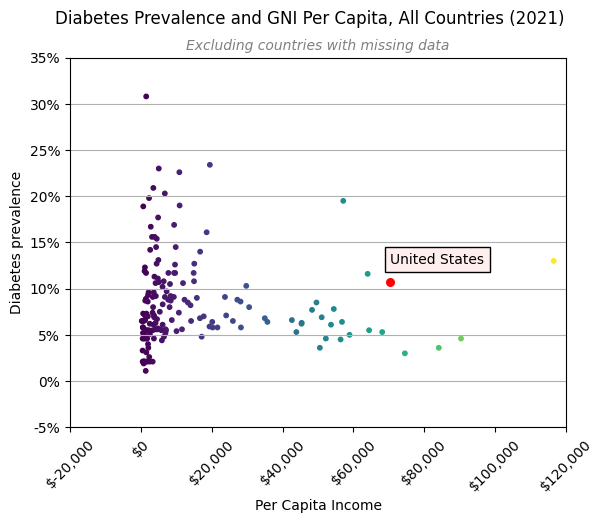

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

dot_size=10

xlim=max(df[ind_gni_per_capita])
ylim=max(df[ind_diabetes])

fig, axis = plt.subplots()
plt.suptitle(f"Diabetes Prevalence and GNI Per Capita, All Countries ({year})")
plt.title("Excluding countries with missing data", color="gray", style="italic",fontsize=10)

X,Y = config_axis(axis,plt,df,xlim,ylim)
axis.scatter(X, Y,s=dot_size,c=df[ind_gni_per_capita])

# Special interest
add_country(df, plt, "United States",box='#ffeeee',c='red')

To my surprise, wealth and diabetes really do not seem to correlate.

As we move up the Y axis on the left edge, we see many lower income countries with *much* higher diabetes rates than the United States and other wealthy countries. 

As we move right along the X axis, we also see higher income countries with some of the lowest diabetes rates.

### Examine the Extremes 

But this chart has almost 200 data points. Let's look separately at:

* Countries with the highest and lowest diabetes prevalence
* Countries with the highest and lowest GNI per capita

In each chart, we'll also include some "reference" countries, like the United States.

:::{note} 
To make the country names readable, I have automatically repositioned them with *adjust_text()*. But this sometimes moves a label rather far from its point, so you can check the data in the ensuing tables.
:::

### Countries with Highest and Lowest Diabetes Prevalence

For reference, we'll also include the countries with the highest and lowest GNI per capita: **Bermuda** and **Burundi**.

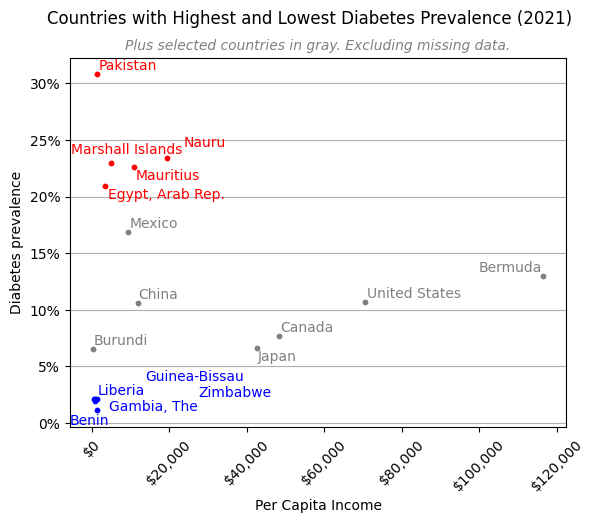

In [66]:
n=5
top_diab = df.sort_values([ind_diabetes])[len(df)-n:]
btm_diab = df.sort_values([ind_diabetes])[0:n]

## Ref countries
ref_countries = ['United States', 'Mexico', 'China', 'Canada', 'Japan']
## Add the richest and poorest countries for reference.
ref_countries.append(df.sort_values([ind_gni_per_capita], ascending=True).iloc[0].name)
ref_countries.append(df.sort_values([ind_gni_per_capita], ascending=False).iloc[0].name)
ref = df.loc[ref_countries]

color_top_diab='red'
color_btm_diab='blue'
color_ref='gray'

chart_subtitle="Plus selected countries in gray. Excluding missing data."


fig, axis = plt.subplots()
plt.suptitle(f"Countries with Highest and Lowest Diabetes Prevalence ({year})")
plt.title(chart_subtitle, color="gray", style="italic",fontsize=10)
# Do not set X and Y this time, but do set the labels.
config_axis(axis,plt,df,xlim,ylim)

plot_countries(axis, plt, top_diab, color_top_diab, dot_size)
plot_countries(axis, plt, btm_diab, color_btm_diab, dot_size)
plot_countries(axis, plt, ref, color_ref, dot_size)

## Use adjust_text to make (most) labels readable
## https://adjusttext.readthedocs.io/en/latest/Examples.html

adjust_text(collect_texts([top_diab,btm_diab,ref],\
                          [color_top_diab,color_btm_diab,color_ref],\
                          xf=ind_gni_per_capita,
                          yf=ind_diabetes),
            expand_text=(1, 1), 
            force_text=(0.25, 0.25),
           )
df2=pd.concat([top_diab, ref, btm_diab])

In [67]:
df2=pd.concat([top_diab, ref, btm_diab])

s(df2,
    [ind_diabetes, ind_gni_per_capita],\
    head=20,\
    countries=list(df2.index),\
    caption=f"Top and bottom diabetes prevalence, with reference countries and GNI per capita")\
    .bar(subset=[ind_diabetes], color=color_diabetes,vmin=0,vmax=max_diab)\
    .bar(subset=[ind_gni_per_capita], color=color_wealth,vmin=0,vmax=max_gni_per_capita)\
    .format({ind_diabetes: fmt_percent, ind_gni_per_capita: fmt_usd})\
    .applymap_index(country_color, countries=list(top_diab.index), color=color_top_diab)\
    .applymap_index(country_color, countries=list(ref.index), color=color_ref)\
    .applymap_index(country_color, countries=list(btm_diab.index), color=color_btm_diab)\
    .set_table_styles(table_styles)

Here, we see that the countries with both the highest and the lowest rates of diabetes have **low** per capita income. 

The highest per capita income here is **Nauru**, with **less than \$20,000/year**, the second is Mauritius with **\$10,860**, and then all the rest, whether the diabetes prevalance is extremely high or extremely low, have a yearly GNI per person of **less than \$10,000**.

True, the countries with the lowest diabetes rates have *extremely* low income, less than **\$2,000** each. One wonders whether the actual prevalence is even higher, given how scarce the resources to gather such statistics may be. 

On the other hand, the country with the highest diabetes rate recorded in 2021, by a wide margin, was **Pakistan**, with a yearly GNI of only **\$1,500**.

It seems very clear that neither low nor high income seems to affect the risk of diabetes.

### Countries with Highest and Lowest GNI Per Capita

To be sure, let's look at countries with the highest and lowest GNI per capita.

For reference, we'll also include countries with the highest and lowest diabetes prevalence: **Pakistan**.

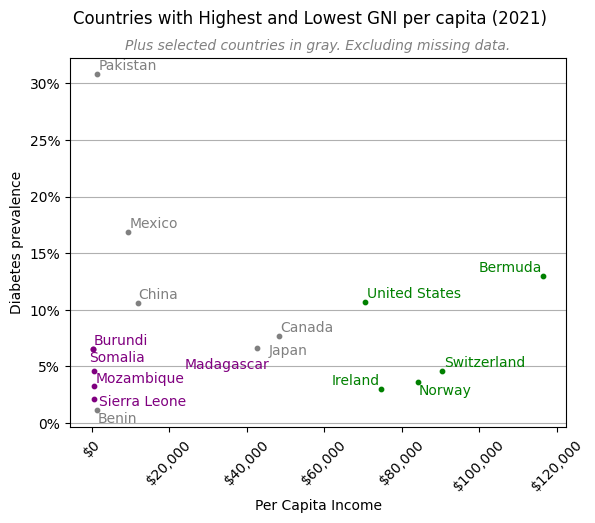

In [68]:
fig, axis = plt.subplots()
plt.suptitle(f"Countries with Highest and Lowest GNI per capita ({year})")
plt.title(chart_subtitle, color="gray", style="italic",fontsize=10)

top_gni = df.sort_values([ind_gni_per_capita])[len(df)-n:]
btm_gni = df.sort_values([ind_gni_per_capita])[0:n]

## Ref countries
ref_countries = ['Mexico', 'China', 'Canada', 'Japan']
## Add the countries with highest and lowest rates of diabetes.
ref_countries.append(df.sort_values([ind_diabetes], ascending=True).iloc[0].name)
ref_countries.append(df.sort_values([ind_diabetes], ascending=False).iloc[0].name)

ref = df.loc[ref_countries]

color_top_gni='green'
color_btm_gni='purple'


# Do not set X and Y this time, but do set the labels.
config_axis(axis,plt,df,xlim,ylim)

plot_countries(axis, plt, top_gni, color_top_gni, dot_size)
plot_countries(axis, plt, btm_gni, color_btm_gni, dot_size)
plot_countries(axis, plt, ref, color_ref, dot_size)

adjust_text(collect_texts([top_gni,btm_gni,ref],\
                          [color_top_gni,color_btm_gni,color_ref],\
                          xf=ind_gni_per_capita,
                          yf=ind_diabetes),
            expand_text=(1, 1), 
            force_text=(0.25, 0.25),
           )
df2=pd.concat([top_gni, ref, btm_gni])

In [69]:
s(df2,
    [ind_gni_per_capita, ind_diabetes],\
    head=20,\
    countries=list(df2.index),\
    caption=f"Top and bottom diabetes prevalence, with reference countries and GNI per capita")\
    .bar(subset=[ind_diabetes], color=color_diabetes,vmin=0,vmax=max_diab)\
    .bar(subset=[ind_gni_per_capita], color=color_wealth,vmin=0,vmax=max_gni_per_capita)\
    .format({ind_diabetes: fmt_percent, ind_gni_per_capita: fmt_usd})\
    .applymap_index(country_color, countries=list(top_gni.index), color=color_top_gni)\
    .applymap_index(country_color, countries=list(ref.index), color=color_ref)\
    .applymap_index(country_color, countries=list(btm_gni.index), color=color_btm_gni)\
    .set_table_styles(table_styles)

Once again, we see no obvious correlation. 

All the lowest income countries have diabetes rates
**lower than 7%**,  but so do three of the five highest income countries, **Switzerland**, **Norway**, and **Ireland**. While Bermuda and the United States have higher rates of 13% and 10.7%, they are nowhere near Pakistan's 30.8%.

We conclude that per capita income simply **does not seem to correlate** with diabetes.

## Conclusion

Whether we focus on diabetes prevalence or per capita income, there doesn't seem to be any correlation between the two.

We find high diabetes rates in both poor and rich countries, and low diabetes rates as well.

Whatever societal factors increase the risk of diabetes, wealth does not seem to show an obvious correlation.

## Acknowledgments

This data was [sourced from the World Bank](https://datatopics.worldbank.org/world-development-indicators/).

The project is my own work.